Stock Index Prediction (for next two days given 50 days data for training and testing)

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.plotting
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [21]:
data = pd.read_csv(r"C:\Users\HP\Downloads\STOCK_INDEX.csv", index_col = 0, header = 0)
df = pd.DataFrame(data)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')

In [22]:
df.isnull().sum()

Open         27
High         27
Low          27
Close        27
Adj Close    27
Volume       27
dtype: int64

Dropping other columns as we are working with only closing price.(It is independent of the others)

In [23]:
df = df[['Close']]
df

,Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2021-04-26,14485.000000
2021-04-27,14653.049810
2021-04-28,14864.549810


In [11]:
rows_with_nan = rows_with_nan = df[df.isnull().any(axis=1)].index
rows_with_nan

DatetimeIndex(['2010-02-06', '2011-05-31', '2011-07-14', '2011-11-24',
               '2011-12-26', '2012-01-02', '2012-01-07', '2012-03-03',
               '2012-05-21', '2012-08-28', '2012-09-08', '2012-11-11',
               '2013-01-01', '2014-01-01', '2014-02-17', '2014-03-22',
               '2014-04-24', '2014-10-15', '2015-01-01', '2015-02-28',
               '2015-04-15', '2016-01-01', '2016-08-12', '2018-01-01',
               '2019-01-01', '2019-10-27', '2020-11-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [12]:
df_linear = df.interpolate(method = "linear")
df_cubic = df.interpolate(method = "cubic")
df_splinecubic = df.interpolate(method = "spline", order=3)

<IPython.core.display.Javascript object>


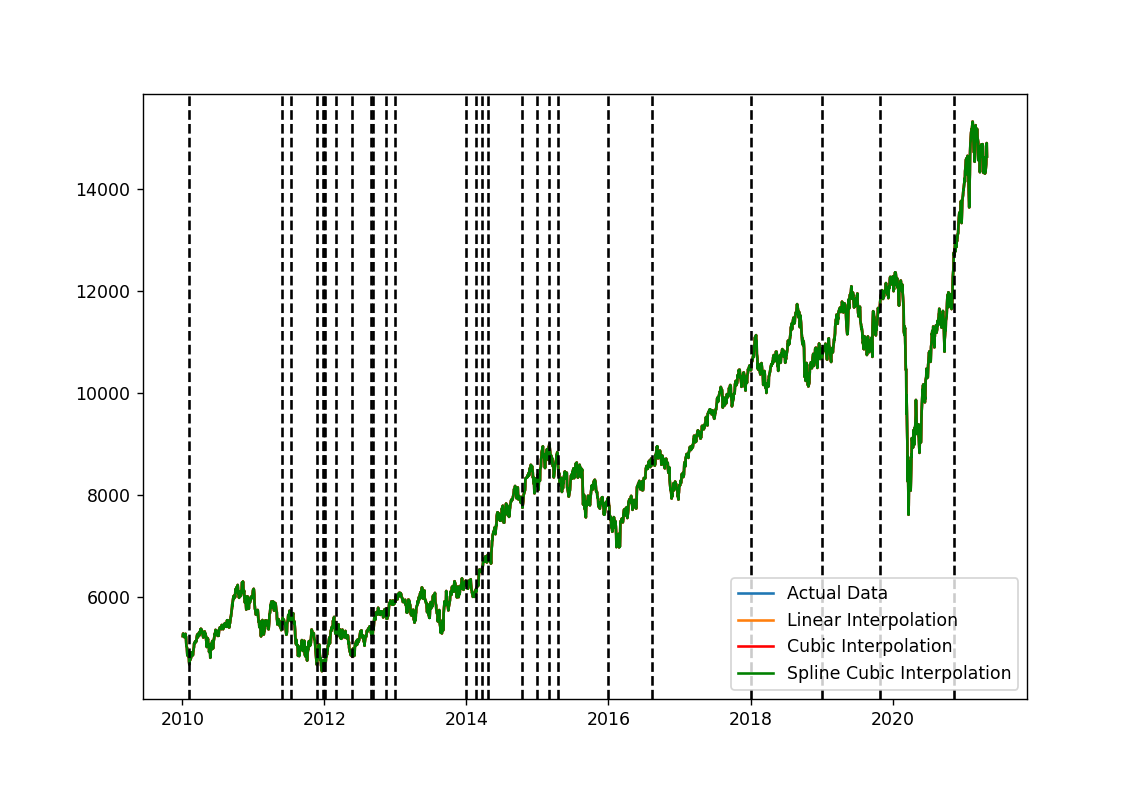

In [13]:
#Plot to check which interpolation suits the best by looking at dates which previously had nan values.
%matplotlib notebook
plt.plot(df, label="Actual Data")
plt.plot(df_linear, label = "Linear Interpolation")
plt.plot(df_cubic, label = "Cubic Interpolation", color="red")
plt.plot(df_splinecubic, label="Spline Cubic Interpolation", color="green")
for i in np.arange(0, 27):
    plt.axvline(x=rows_with_nan[i], color='black', linestyle='--')
plt.legend()

Cubic Interpolation is best for our data (although there is very minute difference between cubic and spline cubic interpolations (approx 0.02-0.04)).

In [24]:
df = df.interpolate(method = "cubic")

<IPython.core.display.Javascript object>


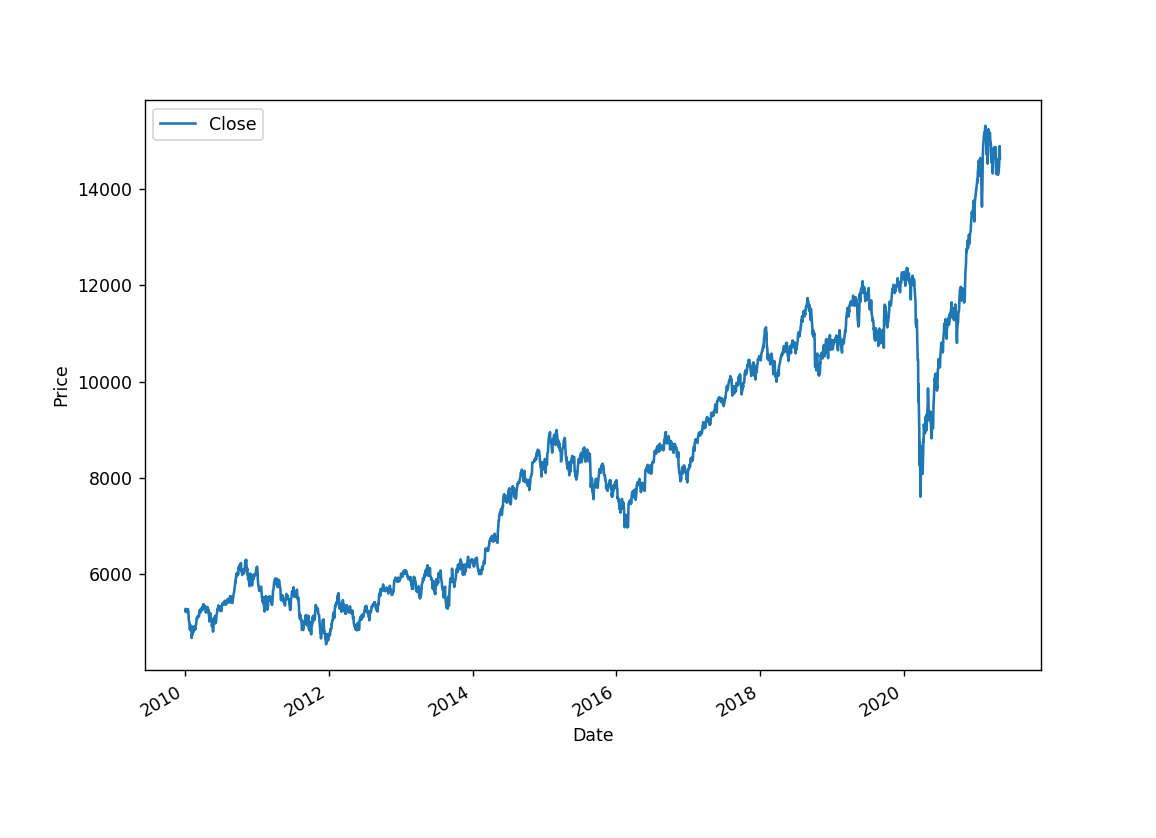

In [95]:
%matplotlib notebook
df.plot()
plt.ylabel("Price")
plt.legend()

In [25]:
ds = df.values
ds

array([[ 5232.200195],
       [ 5277.899902],
       [ 5281.799805],
       ...,
       [14864.54981 ],
       [14894.90039 ],
       [14631.09961 ]])

<IPython.core.display.Javascript object>


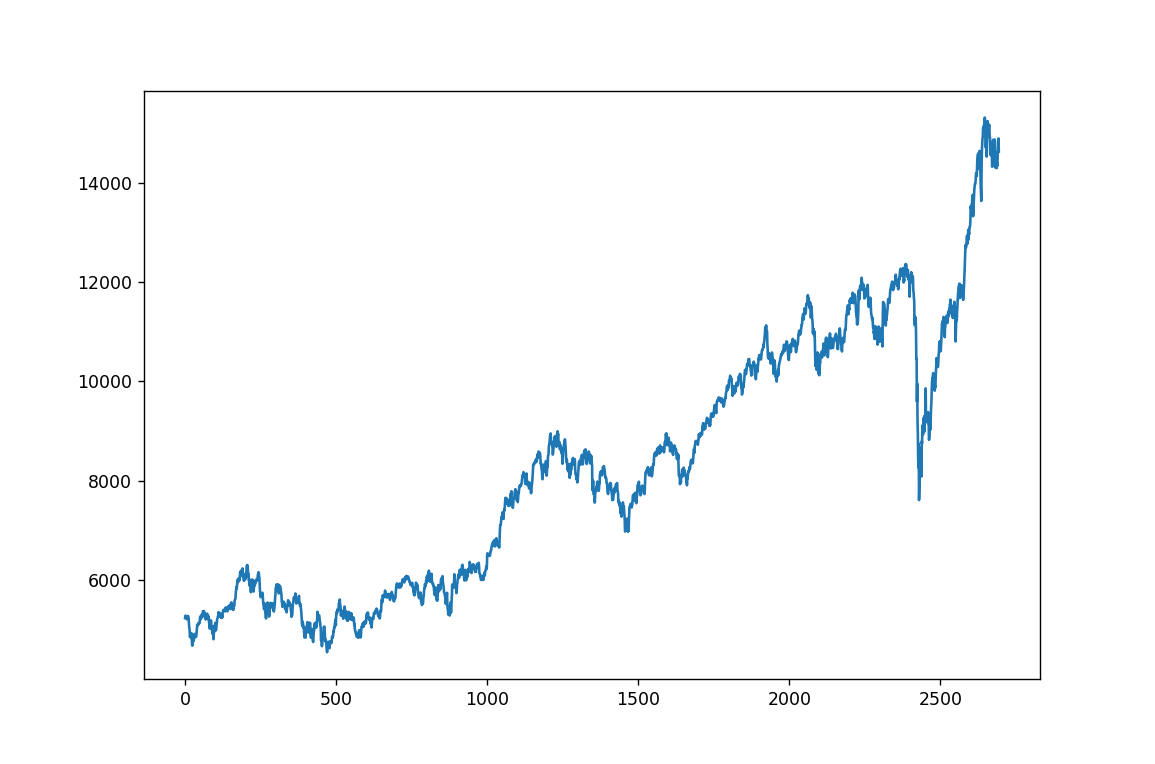

In [97]:
%matplotlib notebook
plt.plot(ds)

In [26]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))
ds_scaled

array([[0.06387819],
       [0.06812123],
       [0.06848332],
       ...,
       [0.95820525],
       [0.96102318],
       [0.93653028]])

In [27]:
len(ds_scaled), len(ds)

(2694, 2694)

In [28]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.80)
test_size = len(ds_scaled) - train_size

In [29]:
train_size,test_size

(2155, 539)

In [30]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [31]:
ds_train

array([[0.06387819],
       [0.06812123],
       [0.06848332],
       ...,
       [0.59059468],
       [0.59075716],
       [0.59585436]])

In [32]:
len(ds_train),len(ds_test)

(2155, 539)

In [33]:
#creating dataset in time series for LSTM model
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [34]:
#Taking 50 days price as one record for training
time_step = 50
X_train, y_train = create_ds(ds_train,time_step)
X_test, y_test = create_ds(ds_test,time_step)

In [35]:
X_train.shape,y_train.shape

((2104, 50), (2104,))

In [36]:
X_test.shape, y_test.shape

((488, 50), (488,))

In [37]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [41]:
# np.random.seed(0)
# tf.random.set_seed(0)

In [74]:
#Creating LSTM model using keras
model = keras.models.Sequential()
model.add(LSTM(units=50,return_sequences=True,activation='tanh',input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1, activation='linear'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_34 (LSTM)              (None, 50, 50)            20200     
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [75]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
33/33 [==============================] - 7s 86ms/step - loss: 0.0133 - val_loss: 0.4409
Epoch 2/100
33/33 [==============================] - 2s 60ms/step - loss: 5.7431e-04 - val_loss: 0.4296
Epoch 3/100
33/33 [==============================] - 2s 61ms/step - loss: 4.1032e-04 - val_loss: 0.4396
Epoch 4/100
33/33 [==============================] - 2s 63ms/step - loss: 3.8367e-04 - val_loss: 0.4454
Epoch 5/100
33/33 [==============================] - 2s 67ms/step - loss: 3.6993e-04 - val_loss: 0.4474
Epoch 6/100
33/33 [==============================] - 2s 64ms/step - loss: 3.7506e-04 - val_loss: 0.4514
Epoch 7/100
33/33 [==============================] - 2s 65ms/step - loss: 3.6531e-04 - val_loss: 0.4561
Epoch 8/100
33/33 [==============================] - 2s 67ms/step - loss: 3.4876e-04 - val_loss: 0.4647
Epoch 9/100
33/33 [==============================] - 2s 67ms/step - loss: 3.4350e-04 - val_loss: 0.4661
Epoch 10/100
33/33 [==============================] - 3s 77ms/step -

<IPython.core.display.Javascript object>


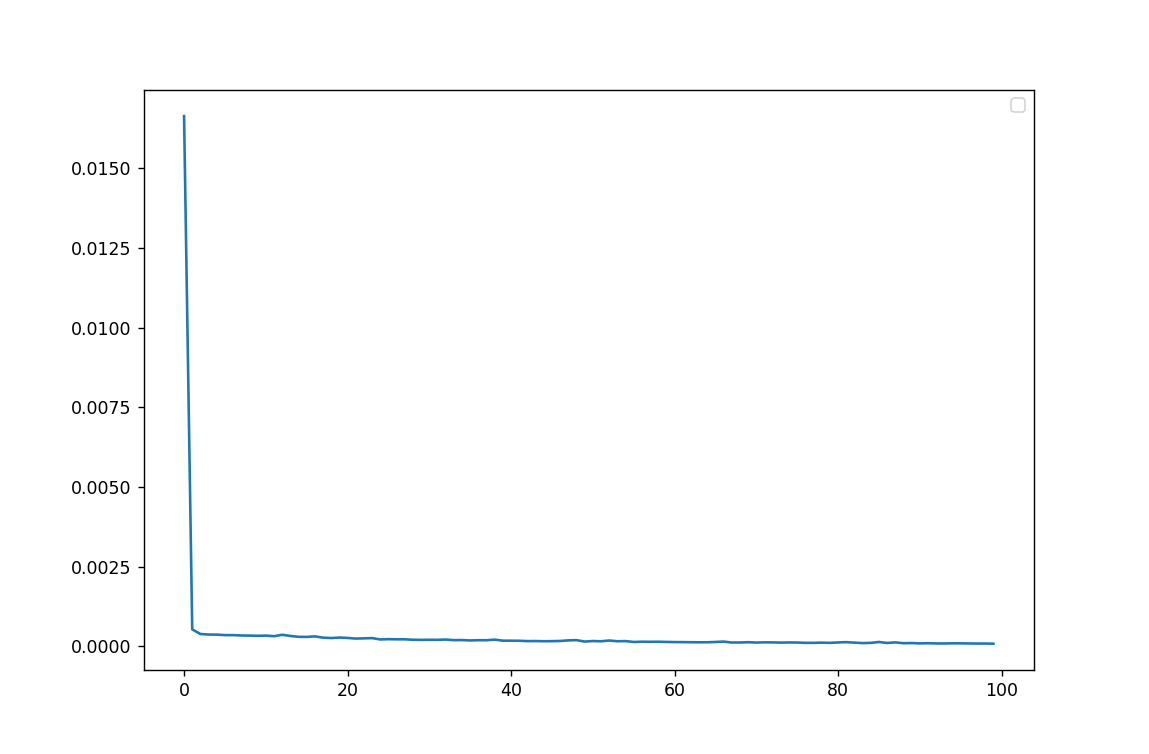

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [112]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
%matplotlib notebook
loss = model.history.history['loss']
plt.plot(loss)
plt.legend()

In [72]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 0s 18ms/step


In [73]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [74]:
train_predict.shape, test_predict.shape

((2104, 1), (488, 1))

In [75]:
rmse = np.sqrt (np.mean(((test_predict- y_test)**2)))
rmse

11902.85604065926

<IPython.core.display.Javascript object>


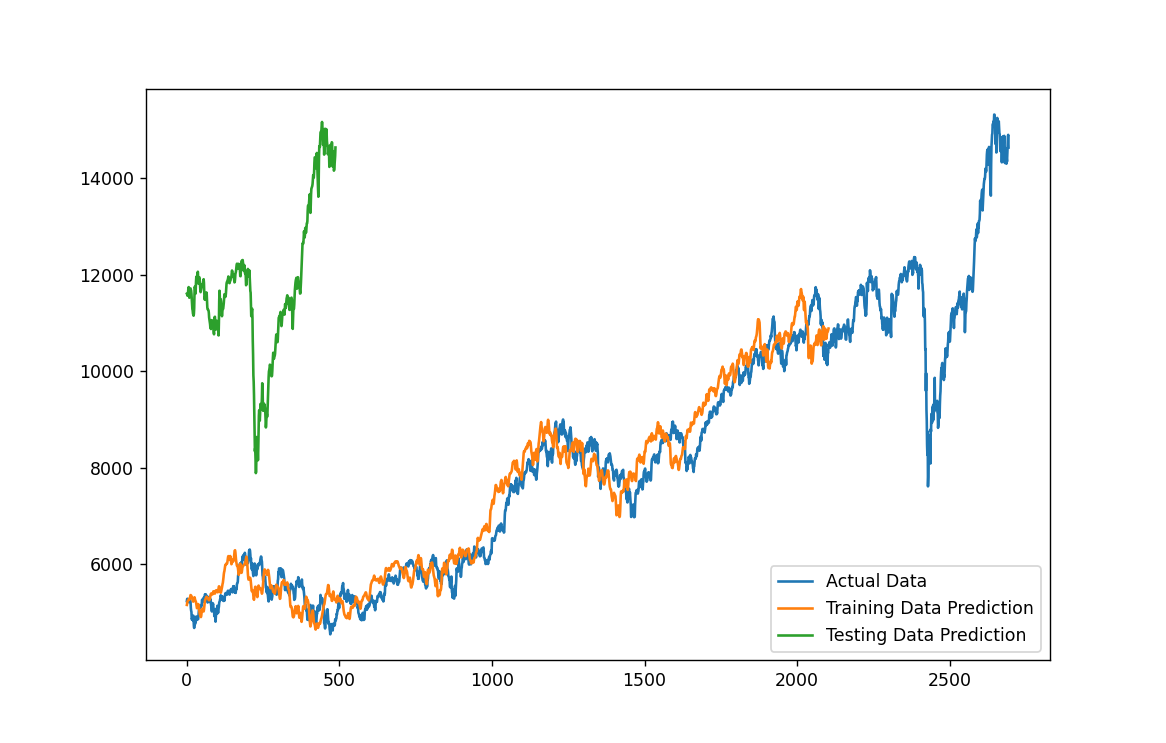

In [76]:
#Comparing using visuals
%matplotlib notebook
plt.plot(normalizer.inverse_transform(ds_scaled), label='Actual Data')
plt.plot(train_predict, label='Training Data Prediction')
plt.plot(test_predict, label='Testing Data Prediction')
plt.legend()

In [77]:
type(train_predict)

numpy.ndarray

In [78]:
len(train_predict)

2104

In [79]:
test = np.vstack((train_predict,test_predict))
test

array([[ 5153.6187],
       [ 5195.1084],
       [ 5223.7983],
       ...,
       [14346.696 ],
       [14458.718 ],
       [14633.011 ]], dtype=float32)

In [80]:
len(test)

2592

In [81]:
train_arr=np.arange(0, 2104)
test_arr=np.arange(2104,2592)

<IPython.core.display.Javascript object>


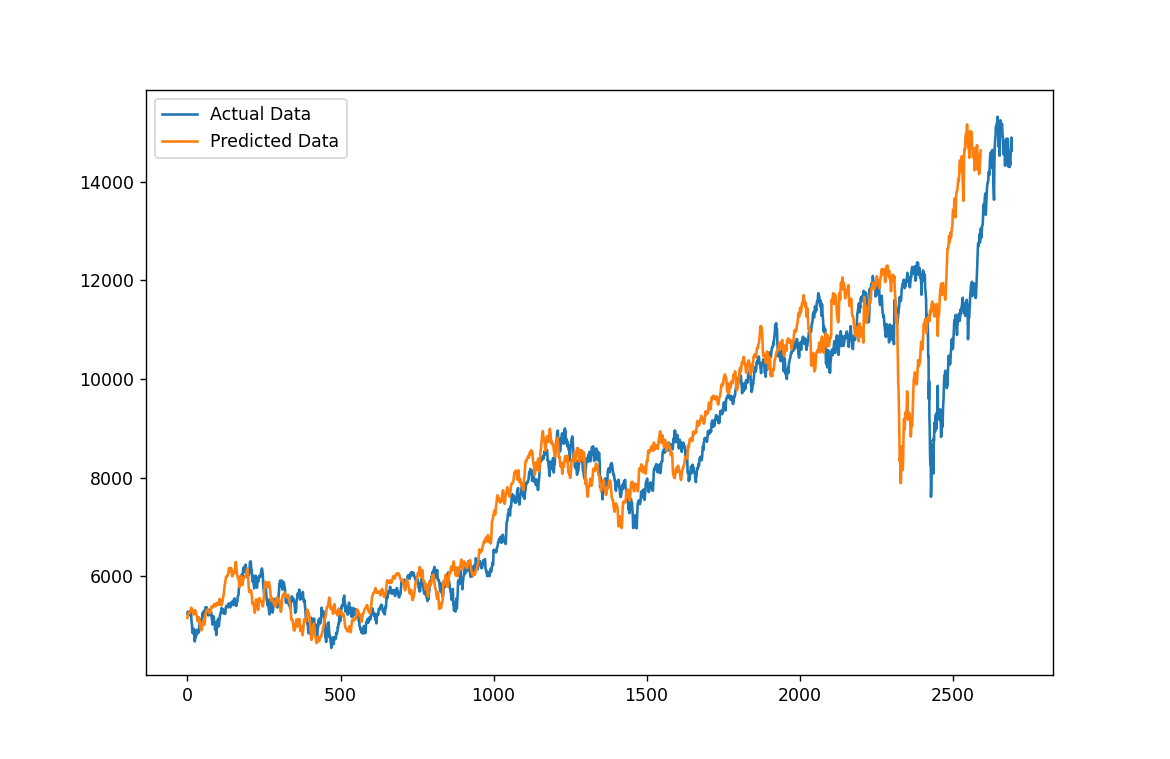

In [82]:
#Combining the predited data to create uniform data visualization
%matplotlib notebook
plt.plot(normalizer.inverse_transform(ds_scaled), label="Actual Data")
# plt.plot(train_arr, train_predict)
# plt.plot(test_arr, test_predict)
plt.plot(test, label="Predicted Data")
plt.legend()

<IPython.core.display.Javascript object>


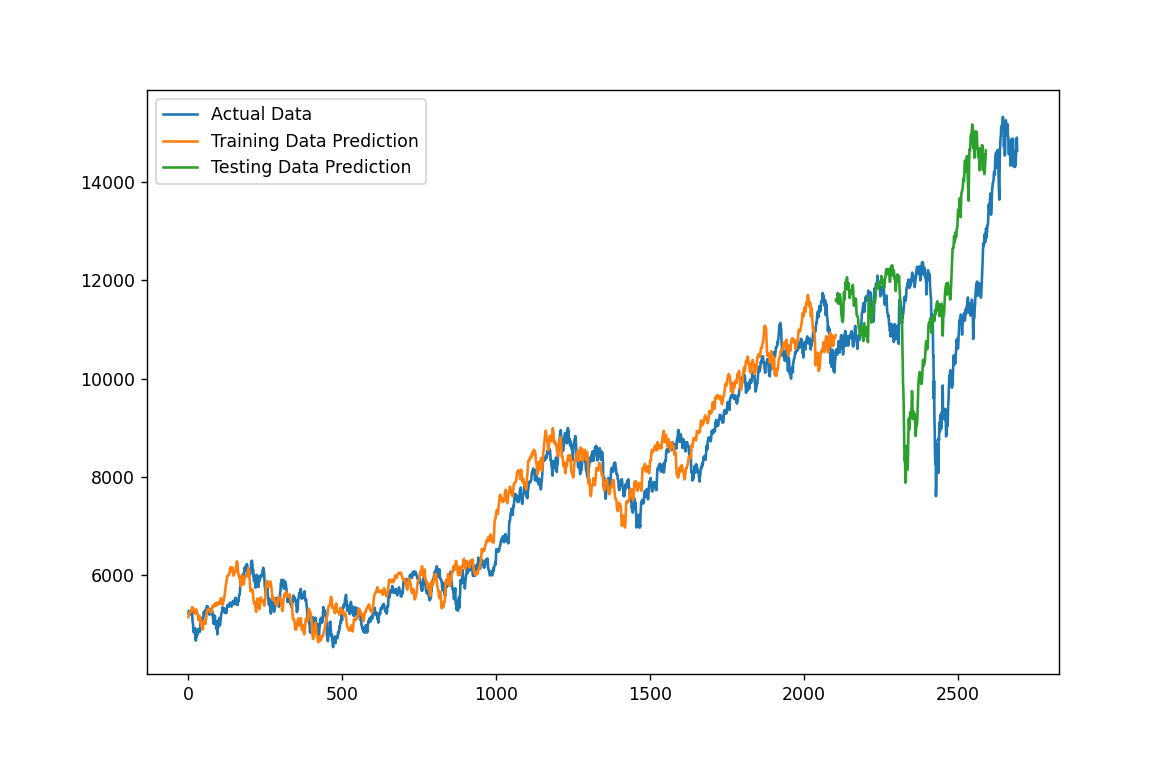

In [83]:
#Differentiating between training and testing data
%matplotlib notebook
plt.plot(normalizer.inverse_transform(ds_scaled), label='Actual Data')
plt.plot(train_arr, train_predict, label='Training Data Prediction')
plt.plot(test_arr, test_predict, label='Testing Data Prediction')
# plt.plot(test)
plt.legend()

In [73]:
#Saving the model
model.save('Model.h5')